# Lab 1: Intro to Remote Sensing and EE

**Purpose**: The purpose of this lab is to enable you to search, find and visualize remotely sensed imagery in Google Earth Engine.  At completion, you should be able to load imagery with the units of interest (radiance or reflectance, for example), make true color and false color composites and identify land cover types based on spectral characteristics.

**Prerequisites**: If you are new to Python or programming, Review the [Earth Engine Code Editor doc and the Get Started guide](https://developers.google.com/earth-engine).




**Searching (and finding) Landsat imagery**

Landsat is a NASA program that has launched a sequence of Earth observation satellites, named Landsat 1, 2,... etc.  Note that the Landsat program has resulted in the longest continuous observation of the Earth's surface.  In this exercise, you will load a Landsat scene over your area of interest, inspect the units and make a plot of radiance.   Specifically, use imagery from the Landsat 8, the most recent of the sequence of Landsat satellites.  To inspect a Landsat 8 image (also called a scene) in your region of interest (ROI), define your ROI as a point, filter the image collection to get a scene with few clouds, display some information about the image in the console.

In [25]:
# # Initializing display and earthengine
# from IPython.display import Image
# %matplotlib inline

import ee
ee.Initialize()

import geemap
import geemap.colormaps as cm

a) Let's find coordinates of a site of your interest using the https://www.latlong.net/ website

In [26]:
latitude = 37.549805
longitude= 45.078629

b) Use the EarthEngine geometry tools to make a point in a location of your interest.  
Name the resultant import 'point'

In [27]:
point = ee.Geometry.Point([longitude, latitude])

c) Search for 'Landsat Surface Corrected' here: https://developers.google.com/earth-engine/datasets/catalog/ and get the handle name (e.g. ee.ImageCollection("XXXXX/XXXX/XXXX"). Name the import 'landsat'.


In [28]:
landsat = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

All the properties of an satellite is also in the datasets catalog

In [29]:
# Note that we need to cast the result of first() to Image.
image = ee.Image(landsat

#    // Filter to get only images in the specified range.This range can be larger
    .filterDate('2022-07-01', '2022-07-31')  # choose a period of no snow

#    // Filter to get only images at the location of the point.This can be a polygon too.
    .filterBounds(point)

#    // Get the first image out of this collection.
    .first()) #so the less cloudy image



The variable "image" now stores a reference to an object of type ee.Image. 

In [30]:
# Print the image band names to the console. Check in GEE website what wavebands these results indicate.
band_names = image.bandNames()
print(band_names.getInfo())

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']


In Landsat Surface Products these bands are also described in the dataset website:


In [31]:
# select only reflectance bands
image = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
# The image requires scaling .
image = image.multiply(2.75e-05).add(-0.2)

 Display the image by printing it to the console:

In [32]:
#// Add the image to the map, using the visualization parameters.
Map = geemap.Map(center=(latitude, longitude), zoom=8)
Map

Map(center=[37.549805, 45.078629], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

In [33]:
# // Center the map and display the image.
#Map.setCenter(-122.1899, 37.5010, 10); # San Francisco Bay
Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, name='Landsat')
Map


Map(center=[37.549805, 45.078629], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

The image is grey because we have not told EarthEngine the min and max values to use. Here is how we define these two characteristics:

In [34]:
#// Define visualization parameters in a dictionary.
# No radiation is represented by zero (min value), and in RGB the average max value is 0.2
trueColor = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0,
  'max': 0.3,
}

In [35]:
#// Add the image to the map, using the visualization parameters.
Map.addLayer(image, trueColor, name='Landsat stretched')
Map

Map(center=[37.549805, 45.078629], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

In [36]:
#// Define false-color visualization parameters.# No radiation is represented by zero (min value), 
# for Infrared the average max value is 0.6

falseColor = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
  'min': 0,
  'max': 0.5
}

In [37]:
#// Add the image to the map, using the visualization parameters.
Map.addLayer(image, falseColor, name='Landsat false color')
Map

Map(center=[37.549805, 45.078629], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

### Visualizing Landsat imagery

Recall that Landsat measures radiance in multiple spectral bands.  A common way to visualize images is to set the red band to display in red, the green band to display in green and the blue band to display in blue.  This means trying to match the spectral response of the instrument to the spectral response of the photoreceptors in the human eye.  It's not a perfect match.  Despite that, a visualization done in this manner is called a true-color image.  When the display bands don't match human visual perception, the resultant visualization is called a false-color composite.  


Let's get the spectral response values for any point in the image

In [38]:
#// Hardcode a point .
point_in_image = ee.Geometry.Point([45.225, 37.92])

#// Define reflective bands as bands B1-B7.  
reflectiveBands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']


#// See http://landsat.usgs.gov/band_designations_landsat_satellites.php
wavelengths = [0.44, 0.48, 0.56, 0.65, 0.86, 1.61, 2.2];

#// Select only the reflectance bands of interest.
reflectanceImage = image.select(reflectiveBands);

In [39]:
# Sample for values at the point.
scale = 30 # pixel size of image

result = reflectanceImage.reduceRegion(ee.Reducer.mean(), point_in_image, scale)
value_info = result.getInfo()

In [40]:
import pandas as pd
df =pd.DataFrame(list(value_info.items()),columns=['Band','Reflectance'])
# # sort bands
df.sort_values('Band', inplace=True) 
# # add wavelenth data to frame
df = df.assign(Wavelength=wavelengths)
df

,Band,Reflectance,Wavelength
0,SR_B1,0.107917,0.44
1,SR_B2,0.137865,0.48
2,SR_B3,0.237305,0.56
3,SR_B4,0.223830,0.65
4,SR_B5,0.014747,0.86
5,SR_B6,0.006937,1.61
6,SR_B7,0.006937,2.20


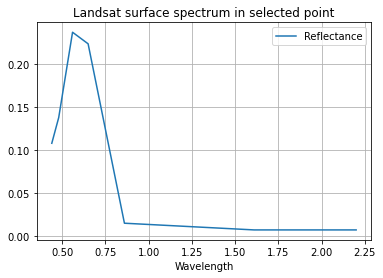

In [41]:
ax =df.plot.line(x='Wavelength', 
             y='Reflectance',
             title= 'Landsat surface spectrum in selected point'
             )
ax.grid()

How to donwload the image?

Google Earth Engine allows dowload of a certain quantity of bytes. This means that it can be less area if the image has multiples bands, or larger areas if the image has a single band. Let's implement a pice of code to download a prt of the image.

First, let's define an area with four coordinates:

In [42]:
geom = ee.Geometry.Polygon(
        [
            [
                [44.988, 37.699],
                [45.309, 37.699],
                [45.309, 37.584],
                [44.988, 37.563],
            ]
        ]
)

feature = ee.Feature(geom, {})

roi = feature.geometry()

In [43]:
import os
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'landsat_example.tif')

In [44]:
image = image.clip(roi).unmask()
geemap.ee_export_image(
    image, filename=filename, scale=60, region=roi, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/data/Downloads/landsat_example.tif
